In [29]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, CategoricalAccuracy
from tensorflow.keras.layers import Conv2D, Conv1D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, UpSampling1D, Softmax, MaxPool1D

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
tqdm.pandas()

print(pd.__version__)
print(tf.__version__)

2.0.2
2.12.0


In [2]:
data_path = save_path = os.path.join('..', '..', 'data', 'mfcc_data')
data_path

'../../data/mfcc_data'

In [3]:
df = pd.read_csv(os.path.join(data_path, 'aa.csv'), sep=',', index_col=False)
df.rename(columns = {'Unnamed: 0':'per_frame_idx'}, inplace = True)
df.head()

,per_frame_idx,mb_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,phonon,asthma_status
0,0,Gaurav,61.123414,9.845393,10.817043,7.056085,7.272934,5.614048,4.491151,4.172515,2.286071,2.837438,2.339272,2.766470,aa_0,Control
1,1,Gaurav,26.805195,23.643036,19.462853,15.425544,12.429753,10.795815,10.223204,10.023100,9.501163,8.302703,6.560850,4.790960,aa_0,Control
2,2,Gaurav,30.082260,25.409986,19.316051,13.504215,9.194826,6.793358,6.015062,6.272963,7.025842,7.901014,8.629334,8.968523,aa_0,Control
3,3,Gaurav,27.535518,24.261880,20.139553,16.368507,13.601135,11.807386,10.589570,9.629306,8.898376,8.510073,8.410082,8.236045,aa_0,Control
4,4,Gaurav,19.493349,17.590766,15.298169,13.292620,11.786129,10.563364,9.328993,8.018267,6.815018,5.924896,5.365196,4.971466,aa_0,Control


In [4]:
df_req = df.drop(['per_frame_idx', 'mb_name', 'phonon'], axis=1)
df_req.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,asthma_status
0,61.123414,9.845393,10.817043,7.056085,7.272934,5.614048,4.491151,4.172515,2.286071,2.837438,2.339272,2.766470,Control
1,26.805195,23.643036,19.462853,15.425544,12.429753,10.795815,10.223204,10.023100,9.501163,8.302703,6.560850,4.790960,Control
2,30.082260,25.409986,19.316051,13.504215,9.194826,6.793358,6.015062,6.272963,7.025842,7.901014,8.629334,8.968523,Control
3,27.535518,24.261880,20.139553,16.368507,13.601135,11.807386,10.589570,9.629306,8.898376,8.510073,8.410082,8.236045,Control
4,19.493349,17.590766,15.298169,13.292620,11.786129,10.563364,9.328993,8.018267,6.815018,5.924896,5.365196,4.971466,Control


In [5]:
df_req['asthma_status'] = df_req['asthma_status'].astype('category')
df_req['asthma_status'] = df_req['asthma_status'].cat.codes
df_req.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,asthma_status
0,61.123414,9.845393,10.817043,7.056085,7.272934,5.614048,4.491151,4.172515,2.286071,2.837438,2.339272,2.766470,0
1,26.805195,23.643036,19.462853,15.425544,12.429753,10.795815,10.223204,10.023100,9.501163,8.302703,6.560850,4.790960,0
2,30.082260,25.409986,19.316051,13.504215,9.194826,6.793358,6.015062,6.272963,7.025842,7.901014,8.629334,8.968523,0
3,27.535518,24.261880,20.139553,16.368507,13.601135,11.807386,10.589570,9.629306,8.898376,8.510073,8.410082,8.236045,0
4,19.493349,17.590766,15.298169,13.292620,11.786129,10.563364,9.328993,8.018267,6.815018,5.924896,5.365196,4.971466,0


In [6]:
df_req['asthma_status'].value_counts()

asthma_status
0    455559
1    319867
Name: count, dtype: int64

In [7]:
Y = df_req.loc[:, 'asthma_status'].to_numpy()
X = df_req.loc[:, df_req.columns != 'asthma_status'].to_numpy()

print(X.shape)
print(Y.shape)

(775426, 12)
(775426,)


In [8]:
# scaler = preprocessing.MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, shuffle=True, random_state=137, stratify=Y)

### Neural Network

In [46]:
def make_model1():
    conv_kernel = 3
    lrelu_p = 0.0
    lr = 0.001

    ### model layout
    model = keras.Sequential(name='Phonon_NN')

    model.add(keras.Input(shape=(12,)))
    model.add(Dense(48*12, name='Reshaping_Dense_1'))
    model.add(LeakyReLU(lrelu_p))
    model.add(Reshape((48, 12)))

    model.add(Conv1D(96, conv_kernel, padding='same', name='Conv1D_1'))
    model.add(LeakyReLU(lrelu_p))
    model.add(UpSampling1D())

    model.add(Conv1D(192, conv_kernel, padding='same', name='Conv1D_2'))
    model.add(LeakyReLU(lrelu_p))
    model.add(MaxPool1D())

    model.add(Conv1D(48, conv_kernel, padding='same', name='Conv1D_3'))
    model.add(LeakyReLU(lrelu_p))

    model.add(Flatten())
    model.add(Dense(48*12, name='Dense_Flatten_1'))
    model.add(LeakyReLU(lrelu_p))

    model.add(Dense(1, activation='softmax', name='Pred_layer'))

    model.summary()

    ### model compiling
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=SGD(learning_rate=lr),
        metrics=[Accuracy(), BinaryAccuracy()]
    )

    return model

In [66]:
def make_model2():
    lr = 0.001

    ### model layout
    model = keras.Sequential(name='Phonon_NN')
    model.add(keras.Input(shape=(12,)))
    model.add(Dense(12*4, activation='linear', name='Dense_1'))
    model.add(Dense(12*8, activation='linear', name='Dense_2'))
    model.add(Dense(12*16, activation='linear', name='Dense_3'))
    model.add(Dense(12*8, activation='linear', name='Dense_4'))
    model.add(Dense(12*4, activation='linear', name='Dense_5'))
    model.add(Dense(1, activation='sigmoid', name='Pred_layer'))

    model.summary()

    ### model compiling
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=Adam(learning_rate=lr),
        metrics=[Accuracy(), BinaryAccuracy()]
    )

    return model

In [10]:
def make_model3():
    conv_kernel = 3
    lrelu_p = 0.0
    lr = 0.001

    ### model layout
    model = keras.Sequential()
    
    model.add(Dense(64, activation='relu', input_shape=(12,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    ### model compiling
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=SGD(learning_rate=lr),
        metrics=[Accuracy(), BinaryAccuracy()]
    )

    return model

In [30]:
def make_model4():
    lr = 0.001

    ### model layout
    model = keras.Sequential()
    
    model.add(Dense(64, activation='relu', input_shape=(12,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    ### model compiling
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=SGD(learning_rate=lr),
        metrics=[Accuracy(), BinaryAccuracy()]
    )

    return model

In [31]:
model_aa = make_model4()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                832       
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33,985
Trainable params: 33,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_aa.fit(x_train, y_train, validation_split=0.20, batch_size=128, epochs=20, use_multiprocessing=True)

In [56]:
# tuned model
def make_model4t(hp):
    lr = 0.001                       
    hp_layer1 = hp.Int('layer1', min_value=64, max_value=512, step=64)
    hp_layer2 = hp.Int('layer2', min_value=64, max_value=512, step=64)
    hp_layer3 = hp.Int('layer3', min_value=64, max_value=512, step=64)
    hp_layer4 = hp.Int('layer4', min_value=64, max_value=512, step=64)

    ### model layout
    model = keras.Sequential(name='Phonon_to_Asthama_NN')
    model.add(keras.Input(shape=(12,)))
    model.add(Dense(units=hp_layer1, activation='relu'))
    model.add(Dense(units=hp_layer2, activation='relu'))
    model.add(Dense(units=hp_layer3, activation='relu'))
    model.add(Dense(units=hp_layer4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    ### model compiling
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=Adam(learning_rate=lr),
        metrics=[BinaryAccuracy()]
    )

    return model

In [54]:
tuner_4t = kt.Hyperband(
    make_model4t,
    objective='val_binary_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuned_models',
    project_name='model_4t2'
)

Model: "Phonon_to_Asthama_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                832       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________


In [55]:
# class BAccHistCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self.losst_history = []
#         self.lossv_history = []
#         self.bat_history = []
#         self.bav_history = []

#     def on_epoch_end(self, epoch, logs=None):
#         self.losst_history.append(logs['binary_accuracy'])
#         self.lossv_history.append(logs['binary_accuracy'])
#         self.bat_history.append(logs['binary_accuracy'])
#         self.bav_history.append(logs['val_binary_accuracy'])

stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
tb_storage = keras.callbacks.TensorBoard("/tmp/tb_logs")
tuner_4t.search(x_train, y_train, epochs=20, validation_split=0.20, batch_size=128, callbacks=[stop_early, tb_storage])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |layer1
288               |288               |layer2
480               |480               |layer3
480               |480               |layer4
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Model: "Phonon_to_Asthama_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 288)               18720     
                                                                 
 dense_2 (Dense)             (None, 480)               138720    
                                    

KeyboardInterrupt: 

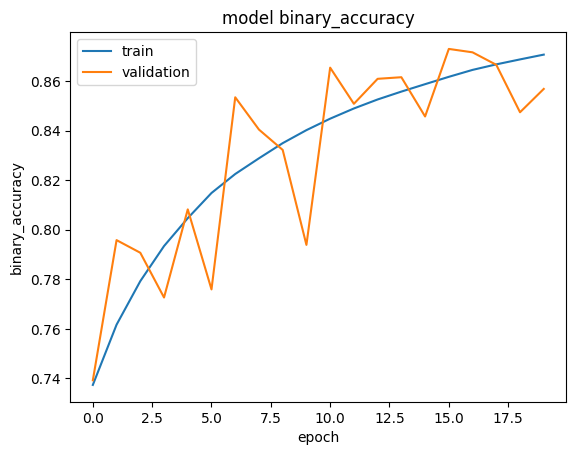

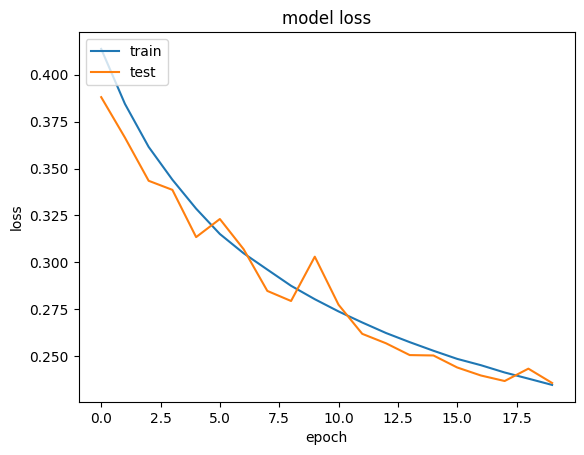

In [34]:
metric_hist = model_aa.history.history

# summarize history for accuracy
plt.plot(metric_hist['binary_accuracy'])
plt.plot(metric_hist['val_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(metric_hist['loss'])
plt.plot(metric_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### SVM

In [28]:
svc = SVC(class_weight='balanced', verbose=True)